In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
import corner
plt.style.use('seaborn-pastel')

In [2]:
# Begin by importing the get_spectrum function from Jon's code.
# Follow this by loading in the data and defining various variables.
# The variables defined here will be called throughout the assignment. 
from planck_likelihood import get_spectrum

planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
spectrum = planck[:,1]
errors = 0.5*(planck[:,2]+planck[:,3])
npts = len(spectrum)
npars = 6
N_inv = np.eye(npts)/(errors**2)

# Question 1

In [3]:
# Using the first set of parameters, compute χ2.
pars_initial=np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
model = get_spectrum(pars_initial, npts)
residuals = spectrum - model
chisq = np.sum((residuals/errors)**2)
print("Using the original set of parameters, χ2 is {0} for {1} degrees of freedom.".format(chisq, npts - npars))

Using the original set of parameters, χ2 is 15267.93877272453 for 2501 degrees of freedom.


In [4]:
# Repeat, but this time using the second set of parameters. 
pars_updated = np.asarray([69, 0.022, 0.12, 0.06, 2.1e-9, 0.95])
updated_model = get_spectrum(pars_updated, npts)
new_res = spectrum - updated_model
chisq_new = np.sum((new_res/errors)**2)
print("Using the updated set of parameters, χ2 is {0} for {1} degrees of freedom.".format(chisq_new, npts - npars))

Using the updated set of parameters, χ2 is 3272.20367430447 for 2501 degrees of freedom.


A discussion of these results is given in the attached PDF.

# Question 2

In [5]:
# In this problem, we utilize LM's method in order to achieve the best fit parameters. 

In [3]:
# First, we need to define a function that computes the numerical derivatives for a given set of parameters.
def get_deriv(pars):
    
    # Initialize matrix to store derivatives.
    deriv_mat = np.empty([npts, npars])
    
    # Vary each parameter by a small amount and compute derivative.
    for i in range(npars):
        
        h_arr = np.zeros(npars)
        h_arr[i] = 0.01*pars[i]
        
        #Compute double sided derivative
        deriv_mat[:, i] = (get_spectrum(pars + h_arr, npts) - get_spectrum(pars - h_arr, npts))/(2*h_arr[i])
    
    return deriv_mat

In [4]:
# Now, we need to define multiple functions that will be used to carry out LM
# First up is update_lamda. I've just copied what was done in class, as nothing needs to be modified.
def update_lamda(lamda, yes):
    if yes: 
        lamda = lamda/1.5
        if lamda < 0.5: 
            lamda = 0
    else: 
        if lamda == 0: 
            lamda = 1
        else:
            lamda = lamda*1.5**2
    return lamda

# Next is a function that easily computes the required matrices required to carry out LM
def get_matrices(pars, N_inv):
    
    # Start by getting the model and derivative matrix 
    model = get_spectrum(pars, npts)
    derivs = get_deriv(pars)
    
    # Compute residual
    r = spectrum - model
    
    #Compute χ2
    lhs = derivs.T@N_inv@derivs
    rhs = derivs.T@N_inv@r
    chisq = r.T@N_inv@r
    
    return chisq, lhs, rhs

# Lastly compute the inverse of the matrix with lamda
def linv(mat, lamda):
    mat = mat + lamda*np.diag(np.diag(mat))
    return np.linalg.inv(mat)
   

In [36]:
# Now onto the main step: Fitting LM
def fit_lm(pars, N_inv, chi_tol = 0.01, max_iterations = 200, pars_prior = None, pars_err = None):
    
    lamda = 0
    # Get initial χ2
    chisq, lhs, rhs = get_matrices(pars, N_inv)
    
    # Keep iterating until chi_tol is satisfied.
    for i in range(max_iterations):
        if i == int(max_iterations/4):
            print('25%...')

        if i == int(max_iterations/2):
            print('50%...')
        
        if i == int(3*max_iterations/4):
            print('75%...')
        
        while True: 
            # Compute covariance matrix
            lhs_inv = linv(lhs, lamda)

            # Compute change in parameters
            dpar = lhs_inv@rhs
            
            # Check to make sure τ isn't giving some unphysical result. Give loose constraints.
            if (pars[3] + dpar[3] > 0.02) and (pars[3] + dpar[3] < 0.1):
                break
            else: 
                # Otherwise, try a new step size.
                lamda = update_lamda(lamda, False)

        
        # Compute trial chisq
        chisq_new, lhs_new, rhs_new = get_matrices(pars + dpar, N_inv)
        
        # Condition to update χ2 if prior is given (For problem 4)
        if pars_prior is not None:
            trial_prior = prior_chisq(pars + dpar, pars_prior, pars_err)
            chisq_new += trial_prior
        
        print('''
Iteration: {0}
Current χ2: {1}
Trial χ2: {2}
λ = {3}      
'''.format(i, chisq, chisq_new, lamda))
        
        # Check to see if χ2 increased or decreased
        if chisq_new < chisq:
            
            # Accept the step
            if lamda == 0.0:
                
                if (np.abs(chisq - chisq_new)<chi_tol):
                    print('Converged!')
                    return pars + dpar, lhs_new
            
            # If not close to the minimum, try a new step, making sure to update all parameters.
            chisq = chisq_new
            lhs = lhs_new
            rhs = rhs_new
            pars += dpar
            lamda = update_lamda(lamda, True)
        
        # Else, reject step and try a bigger step.
        else: 
            lamda = update_lamda(lamda, False)
        
    
    print('Max iterations achieved. Stopping program.')
    return pars, lhs
        

In [ ]:
# Begin by defining our starting set of parameters. 
pars_start = np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
# Get best fit parameters and their errors.
best_fit_pars, cov_inv = fit_lm(pars_start, N_inv)  

In [10]:
#Get the error on the parameters by taking the square root of the diagonal of the inverse of "lhs"
cov = np.linalg.inv(cov_inv)
err_params = np.sqrt(np.diag(cov))

H0, ombh2, omch2, tau, As, ns = best_fit_pars
err0, err1, err2, err3, err4, err5 = err_params
print('''
Best Fit Parameters:
--------------------

H0 = {0} ± {1}
Ωbh\u00b2 = {2} ± {3}
ΩCh\u00b2 = {4} ± {5}
τ = {6} ± {7}
As = {8} ± {9}
ns = {10} ± {11}

'''.format(H0, err0, ombh2, err1, omch2, err2, tau, err3, As, err4, ns, err5))

#Save curvature matrix for next problem.
np.savetxt('curvature_matrix_bestfit.txt', cov)

#Save best fit parameters and errors. 
np.savetxt('planck_fit_params.txt', np.vstack((best_fit_pars, err_params)))


Best Fit Parameters:
--------------------

H0 = 67.8195027043325 ± 1.172374079446999
Ωbh² = 0.022296234954382668 ± 0.00023078326288458316
ΩCh² = 0.11855495140289309 ± 0.0026344328193545303
τ = 0.044152061839308955 ± 0.037889197064791866
As = 2.0484751392680914e-09 ± 1.4872102878336434e-10
ns = 0.9707540097728851 ± 0.0062811422883403975




# Question 3

In [41]:
# The goal of this question is to get an MCMC working, using prior knowledge of the stepsize. 
# Let's start by defining a few fundamental functions. 

# Get χ2 for a set of parameters with noise
def get_chisq(pars, noise = errors):
    
    model = get_spectrum(pars, npts)
    r = spectrum - model
    chisq = np.sum((r/noise)**2)
    
    return chisq

# Cholesky decomposition
def cholesky_decomp(mat):
    return np.linalg.cholesky(mat)


# Main MCMC function
def MCMC(pars, curv_mat, nstep, noise = errors, pars_prior = None, pars_err = None):
    
    # Get starting χ2 value
    chi_cur = get_chisq(pars, noise)
    
    # Initialize chain and χ2 vector
    chain = np.zeros([nstep, npars])
    chi_vec = np.zeros(nstep)
    
    # Track how many trials get accepted. Expect 25%.
    accepted_counter = 0
    
    # Get cholesky decomposition
    cholesky_mat = cholesky_decomp(curv_mat)
    
    # Begin chain
    for i in range(nstep):
        
        if i == int(nstep/4):
            print('25% Complete.')

        if i == int(nstep/2):
            print('50% Complete.')
        
        if i == int(3*nstep/4):
            print('75% Complete.')
            
        # Make sure that τ stays as a reasonable value
        while True: 
            
            # Generate random step using cholesky decomp
            dpar = cholesky_mat@np.random.randn(npars)

            # Check to see if τ becomes unphysical. If yes, try another step.
            if (pars[3] + dpar[3] > 0.02) and (pars[3] + dpar[3] < 0.1):
                break
        
        # Update parameters
        trial_pars = pars + dpar
        trial_chisq = get_chisq(trial_pars, noise)
        
        # Condition to update χ2 if prior is given (For problem 4)
        if pars_prior is not None: 
            trial_chisq += prior_chisq(trial_pars, pars_prior, pars_err)
            
        # Compute change in χ2
        dchisq = trial_chisq - chi_cur
        
        # Get probability of accepting
        prob_accept = np.exp(-0.5*dchisq)
        accept = np.random.rand(1) < prob_accept
        
        # If accepted, set new parameters and move on to step.
        if accept: 
            accepted_counter +=1
            pars = trial_pars
            chi_cur = trial_chisq
            
        
        chain[i,:] = pars
        chi_vec[i] = chi_cur
        
    print('Out of {0} steps, {1} were accepted ({2}%).'.format(nstep, accepted_counter, 100*accepted_counter/nstep))
    
    return chain, chi_vec 

In [12]:
# Set starting parameters and load in best fit curvature matrix from Question 2. 
pars_start = np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
cov = np.loadtxt('curvature_matrix_bestfit.txt')

# Run MCMC
chain, chisq = MCMC(pars_start, cov, 7000)

# Save data
data = np.empty((len(chisq), npars + 1))
data[:,0] = chisq
for i in range(npars):
    data[:, i + 1] = chain[:, i]

np.savetxt('planck_chain.txt', data)

25% Complete.
50% Complete.
75% Complete.
Out of 7000 steps, 1670 were accepted (23.857142857142858%).


##### All plotting related parts of the problem can be found below

In [63]:
# Read in data for plotting purposes
data = np.loadtxt('planck_chain.txt').T
chisq = data[0,:]
H0 = data[1, :]
omega_bh2 = data[2, :]
omega_ch2 = data[3,: ]
τ = data[4,: ]
A_s = data[5,: ]
n_s = data[6, :]

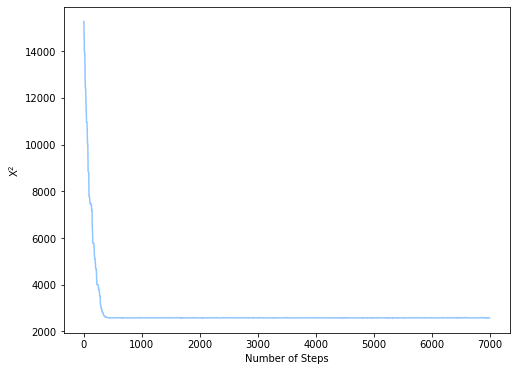

In [75]:
# Plot χ2
plt.figure(figsize = (8,6))
plt.plot(chisq)
plt.xlabel('Number of Steps')
plt.ylabel('Χ$^2$')
plt.savefig('chi2_full')
plt.show()

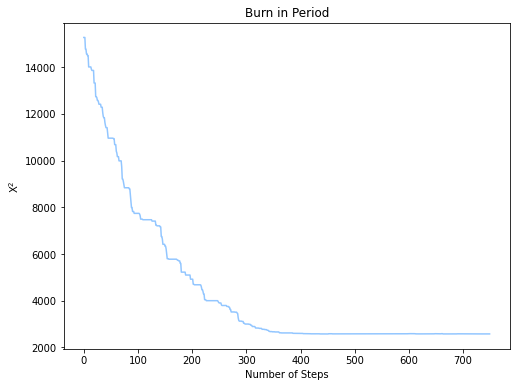

In [43]:
# Notice that in the above plot, the Burn-in occurs until roughly step 400.
plt.figure(figsize = (8,6))
plt.plot(chisq[0:750])
plt.xlabel('Number of Steps')
plt.title('Burn in Period')
plt.ylabel('Χ$^2$')
plt.savefig('chi2')
plt.show()

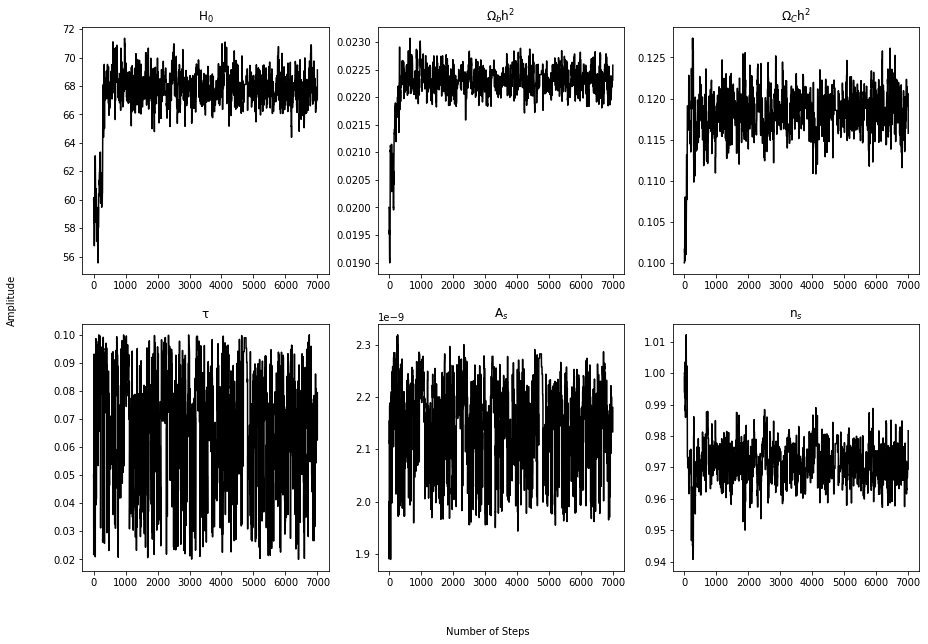

In [62]:
# Plot pure chains as a function of step, including burn in period.
fig, axs = plt.subplots(2,3)
fig.set_figheight(10)
fig.set_figwidth(15)

axs[0,0].plot(H0, color = 'black')
axs[0,0].set_title('H$_0$')


axs[0,1].plot(omega_bh2, color = 'black')
axs[0,1].set_title('Ω$_b$h$^2$')

axs[0,2].plot(omega_ch2, color = 'black')
axs[0,2].set_title('Ω$_C$h$^2$')

axs[1,0].plot(τ, color = 'black')
axs[1,0].set_title('τ')

axs[1,1].plot(A_s, color = 'black')
axs[1,1].set_title('A$_s$')

axs[1,2].plot(n_s, color = 'black')
axs[1,2].set_title('n$_s$')

fig.text(0.5, 0.04, 'Number of Steps', ha = 'center', va = 'center')
fig.text(0.06, 0.5, 'Amplitude', ha='center', va='center', rotation='vertical')
plt.savefig('amplitudes_vs_time_with_burnin')
plt.show()

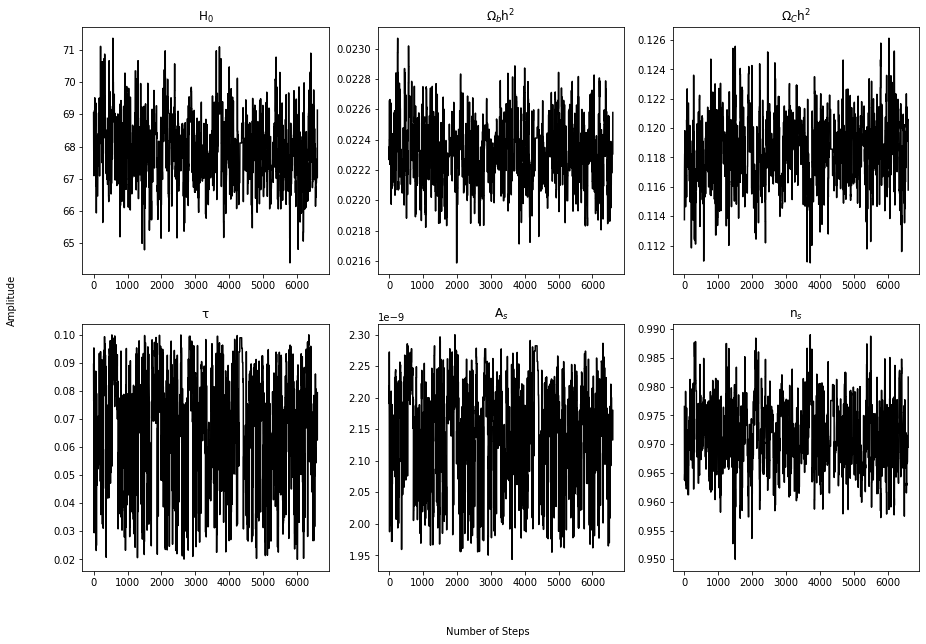

In [63]:
# Plot pure chains as a function of step, excluding burn in period.
fig, axs = plt.subplots(2,3)
fig.set_figheight(10)
fig.set_figwidth(15)

axs[0,0].plot(H0[400:], color = 'black')
axs[0,0].set_title('H$_0$')


axs[0,1].plot(omega_bh2[400:], color = 'black')
axs[0,1].set_title('Ω$_b$h$^2$')

axs[0,2].plot(omega_ch2[400:], color = 'black')
axs[0,2].set_title('Ω$_C$h$^2$')

axs[1,0].plot(τ[400:], color = 'black')
axs[1,0].set_title('τ')

axs[1,1].plot(A_s[400:], color = 'black')
axs[1,1].set_title('A$_s$')

axs[1,2].plot(n_s[400:], color = 'black')
axs[1,2].set_title('n$_s$')

fig.text(0.5, 0.04, 'Number of Steps', ha = 'center', va = 'center')
fig.text(0.06, 0.5, 'Amplitude', ha='center', va='center', rotation='vertical')
plt.savefig('amplitudes_vs_time_no_burnin')
plt.show()

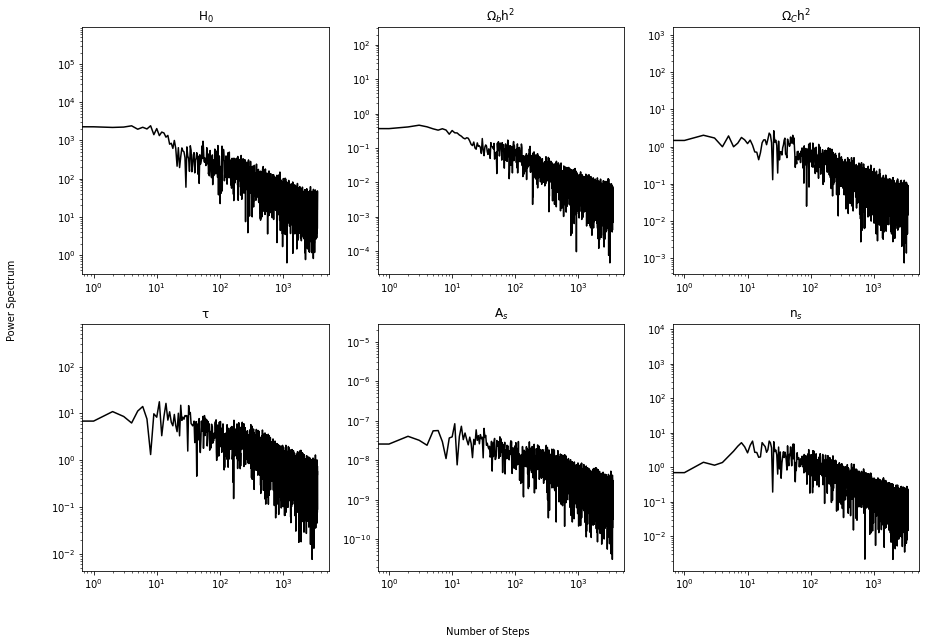

In [57]:
#Plot power spectrums
fig, axs = plt.subplots(2,3)
fig.set_figheight(10)
fig.set_figwidth(15)

axs[0,0].loglog(np.abs(np.fft.rfft(H0)), color = 'black')
axs[0,0].set_title('H$_0$')


axs[0,1].loglog(np.abs(np.fft.rfft(omega_bh2)), color = 'black')
axs[0,1].set_title('Ω$_b$h$^2$')

axs[0,2].loglog(np.abs(np.fft.rfft(omega_ch2)), color = 'black')
axs[0,2].set_title('Ω$_C$h$^2$')

axs[1,0].loglog(np.abs(np.fft.rfft(τ)), color = 'black')
axs[1,0].set_title('τ')

axs[1,1].loglog(np.abs(np.fft.rfft(A_s)), color = 'black')
axs[1,1].set_title('A$_s$')

axs[1,2].loglog(np.abs(np.fft.rfft(n_s)), color = 'black')
axs[1,2].set_title('n$_s$')

fig.text(0.5, 0.04, 'Number of Steps', ha = 'center', va = 'center')
fig.text(0.06, 0.5, 'Power Spectrum', ha='center', va='center', rotation='vertical')
plt.savefig('power spectrum')
plt.show()

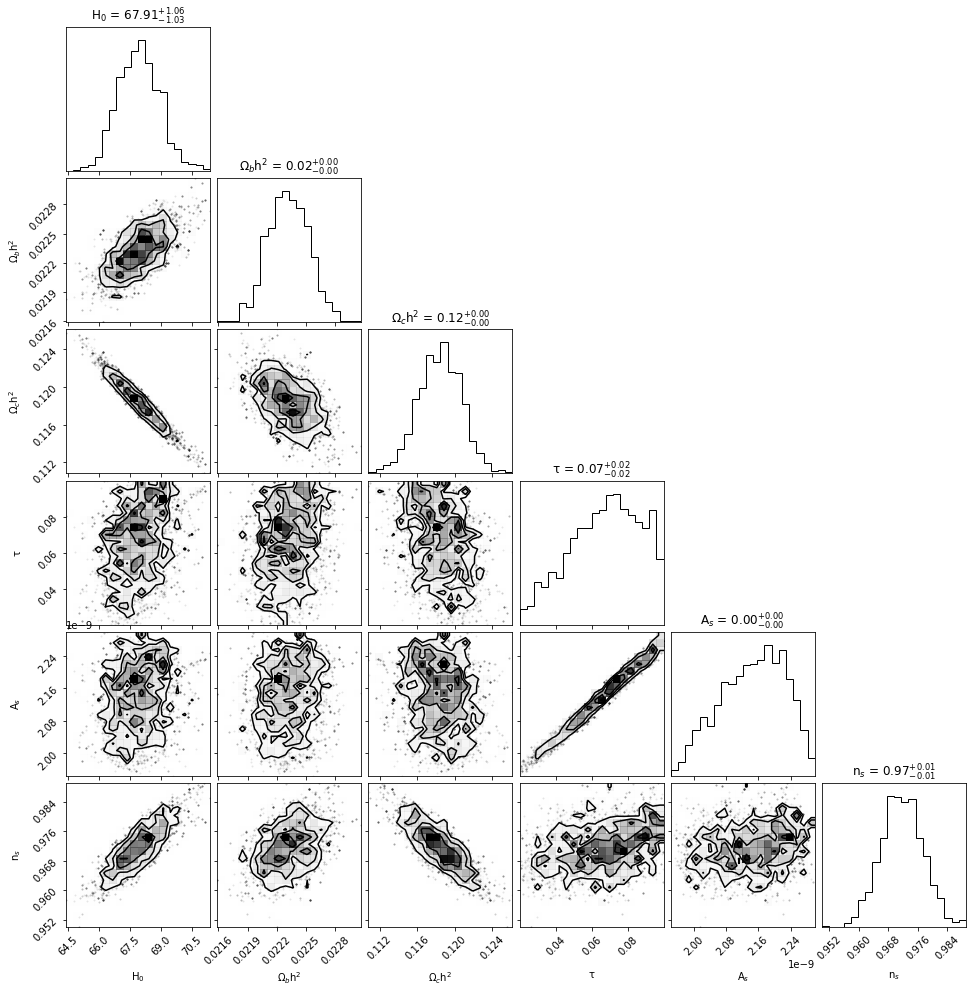

In [61]:
#Get Corner Plots, excluding burn in periods.
pars = data[1:,400:]
corner.corner(pars.T, labels = ["H$_0$", "Ω$_b$h$^2$", 'Ω$_c$h$^2$', 'τ', 'A$_s$', 'n$_s$'], show_titles=True, title_fmt='.2f')
plt.savefig('corner_plot')
plt.show()

In [64]:
# Let's now determine the best fit parameters by taking the mean after the burn in period
best_fit_pars = np.mean(data[1:,400:], axis = 1)
err_params = np.std(data[1:,400:], axis = 1)

H0, ombh2, omch2, tau, As, ns = best_fit_pars
err0, err1, err2, err3, err4, err5 = err_params
print('''
Best Fit Parameters:
--------------------

H0 = {0} ± {1}
Ωbh\u00b2 = {2} ± {3}
ΩCh\u00b2 = {4} ± {5}
τ = {6} ± {7}
As = {8} ± {9}
ns = {10} ± {11}

'''.format(H0, err0, ombh2, err1, omch2, err2, tau, err3, As, err4, ns, err5))


Best Fit Parameters:
--------------------

H0 = 67.91996557045465 ± 1.012559494450016
Ωbh² = 0.022319445791911904 ± 0.00020817891326858172
ΩCh² = 0.11839419872358399 ± 0.002290860254042035
τ = 0.06743922048326015 ± 0.018947498631119407
As = 2.1456169749757675e-09 ± 7.780355764787577e-11
ns = 0.9716768664542087 ± 0.005684250893450246




In [65]:
# Estimate Ω_Λ
h = H0/100
omega_lamda = 1 - (ombh2 + omch2)/(h**2)
err_omlam = omega_lamda*((ombh2/err1)**-2 + (omch2/err2)**-2 + 8*(err0/H0)**2)**(1/2)
print('''
Ωλ = {0} \pm {1}
'''.format(omega_lamda, err_omlam))


Ωλ = 0.6949708831416036 \pm 0.03288773753461801



# Question 4

In [37]:
# To begin this question, we need to re-estimate the covariance matrix using importance sampling. In both
# fit_lm and MCMC, I've included two parameters, par_priors and par_errs. If we add in these parameters,
# an updated χ2 will be calculated to take into account these priors using the below function:

def prior_chisq(pars, pars_prior, pars_err):
    par_shifts = pars - pars_prior 
    return np.sum((par_shifts/pars_err)**2)

In [ ]:
# Set priors
pars_prior = np.array([0.0,0.0,0.0, 0.0540, 0.0, 0.0])
pars_err = np.zeros(npars) + 1e20
pars_err[3] = 0.0074

# Initial guess
pars_start = np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])

# Get updated parameter covariance matrix
best_fit_pars, cov_inv = fit_lm(pars_start, N_inv, pars_prior = pars_prior, pars_err = pars_err, max_iterations = 200)

#Save updated curvature matrix for next problem.
np.savetxt('curvature_matrix_bestfit_tauprior.txt', np.linalg.inv(cov_inv))

In [42]:
# Run MCMC with updated covariance matrix
cov_tauprior = np.loadtxt('curvature_matrix_bestfit_tauprior.txt')

chains_prior, chisq_prior = MCMC(pars_start, cov_tauprior, 7000, pars_prior = pars_prior, pars_err = pars_err)

# Save data
data = np.empty((len(chisq_prior), npars + 1))
data[:,0] = chisq_prior
for i in range(npars):
    data[:, i + 1] = chains_prior[:, i]

np.savetxt('planck_chain_tauprior.txt', data)

25% Complete.
50% Complete.
75% Complete.
Out of 7000 steps, 1004 were accepted (14.342857142857143%).


In [43]:
# Read in data for plotting purposes
data = np.loadtxt('planck_chain_tauprior.txt').T
chisq = data[0,:]
H0 = data[1, :]
omega_bh2 = data[2, :]
omega_ch2 = data[3,: ]
τ = data[4,: ]
A_s = data[5,: ]
n_s = data[6, :]

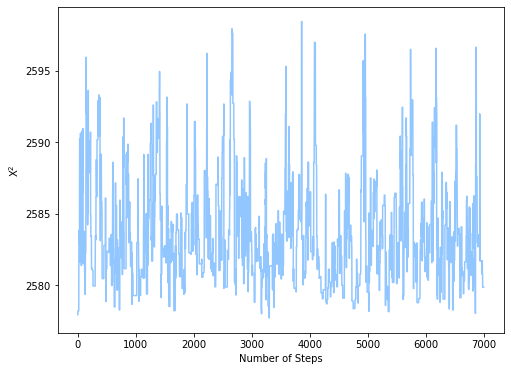

In [44]:
# Plot χ2
plt.figure(figsize = (8,6))
plt.plot(chisq)
plt.xlabel('Number of Steps')
plt.ylabel('Χ$^2$')
plt.savefig('chi2_full_tauprior')
plt.show()

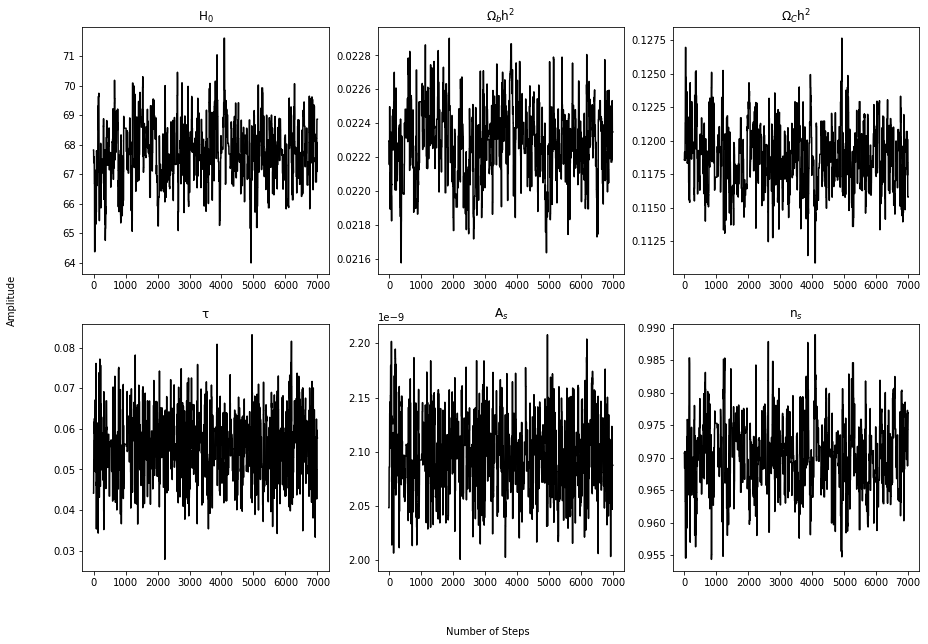

In [46]:
# Plot pure chains as a function of step, including burn in period.
fig, axs = plt.subplots(2,3)
fig.set_figheight(10)
fig.set_figwidth(15)

axs[0,0].plot(H0, color = 'black')
axs[0,0].set_title('H$_0$')


axs[0,1].plot(omega_bh2, color = 'black')
axs[0,1].set_title('Ω$_b$h$^2$')

axs[0,2].plot(omega_ch2, color = 'black')
axs[0,2].set_title('Ω$_C$h$^2$')

axs[1,0].plot(τ, color = 'black')
axs[1,0].set_title('τ')

axs[1,1].plot(A_s, color = 'black')
axs[1,1].set_title('A$_s$')

axs[1,2].plot(n_s, color = 'black')
axs[1,2].set_title('n$_s$')

fig.text(0.5, 0.04, 'Number of Steps', ha = 'center', va = 'center')
fig.text(0.06, 0.5, 'Amplitude', ha='center', va='center', rotation='vertical')
plt.savefig('amplitudes_vs_time_with_burnin_tauprior')
plt.show()

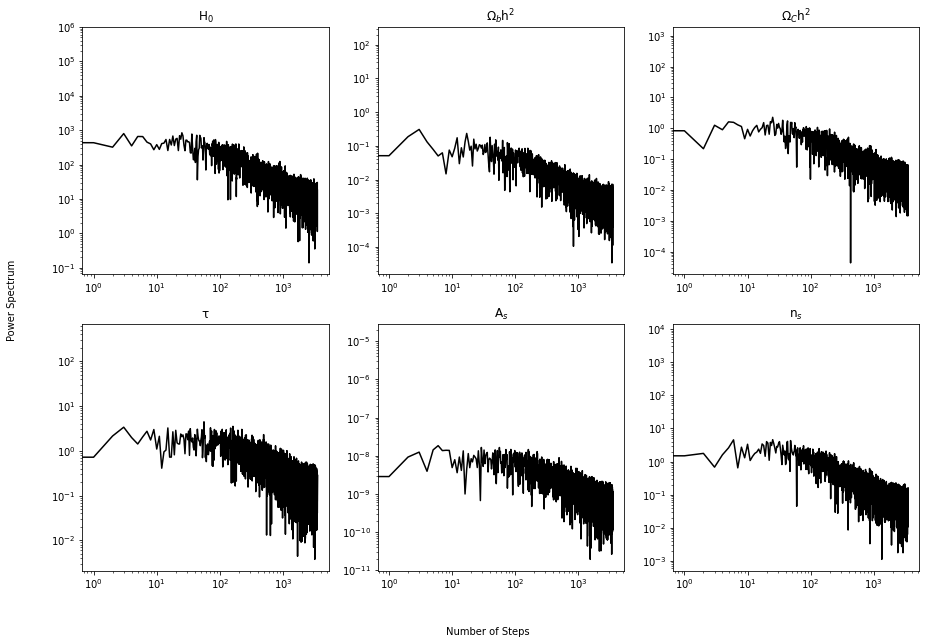

In [47]:
#Plot power spectrums
fig, axs = plt.subplots(2,3)
fig.set_figheight(10)
fig.set_figwidth(15)

axs[0,0].loglog(np.abs(np.fft.rfft(H0)), color = 'black')
axs[0,0].set_title('H$_0$')


axs[0,1].loglog(np.abs(np.fft.rfft(omega_bh2)), color = 'black')
axs[0,1].set_title('Ω$_b$h$^2$')

axs[0,2].loglog(np.abs(np.fft.rfft(omega_ch2)), color = 'black')
axs[0,2].set_title('Ω$_C$h$^2$')

axs[1,0].loglog(np.abs(np.fft.rfft(τ)), color = 'black')
axs[1,0].set_title('τ')

axs[1,1].loglog(np.abs(np.fft.rfft(A_s)), color = 'black')
axs[1,1].set_title('A$_s$')

axs[1,2].loglog(np.abs(np.fft.rfft(n_s)), color = 'black')
axs[1,2].set_title('n$_s$')

fig.text(0.5, 0.04, 'Number of Steps', ha = 'center', va = 'center')
fig.text(0.06, 0.5, 'Power Spectrum', ha='center', va='center', rotation='vertical')
plt.savefig('power spectrum tauprior')
plt.show()

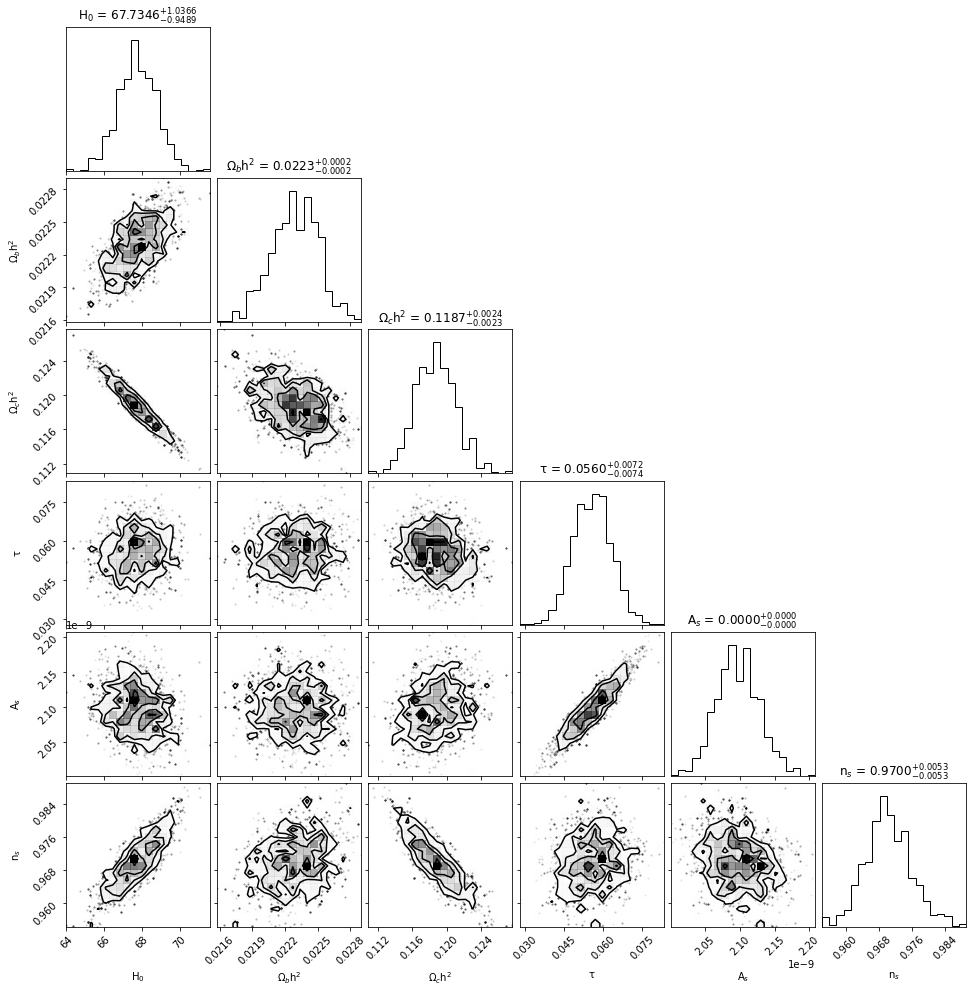

In [54]:
#Get Corner Plots, excluding burn in periods.
pars = data[1:,:]
corner.corner(pars.T, labels = ["H$_0$", "Ω$_b$h$^2$", 'Ω$_c$h$^2$', 'τ', 'A$_s$', 'n$_s$'], show_titles=True, title_fmt='.4f')
plt.savefig('corner_plot_tauprior_2')
plt.show()

In [59]:
# Let's now determine the best fit parameters by taking the mean after the burn in period
best_fit_pars = np.mean(data[1:,:], axis = 1)
err_params = np.std(data[1:,:], axis = 1)

H0, ombh2, omch2, tau, As, ns = best_fit_pars
err0, err1, err2, err3, err4, err5 = err_params
print('''
Best Fit Parameters:
--------------------

H0 = {0} ± {1}
Ωbh\u00b2 = {2} ± {3}
ΩCh\u00b2 = {4} ± {5}
τ = {6} ± {7}
As = {8} ± {9}
ns = {10} ± {11}

'''.format(H0, err0, ombh2, err1, omch2, err2, tau, err3, As, err4, ns, err5))


Best Fit Parameters:
--------------------

H0 = 67.59374328499617 ± 1.8710726382271097
Ωbh² = 0.022263224882613498 ± 0.0003655794590387099
ΩCh² = 0.11819376854539951 ± 0.0028227657961231905
τ = 0.06817703929535626 ± 0.01929707137913444
As = 2.1482145329003753e-09 ± 8.01235544560827e-11
ns = 0.9717392884714818 ± 0.006636534400110004




In [62]:
# Estimate Dark Energy
h = H0/100
omega_lamda = 1 - (ombh2 + omch2)/(h**2)
err_omlam = omega_lamda*((ombh2/err1)**-2 + (omch2/err2)**-2 + 8*(err0/H0)**2)**(1/2)
print('''
Dark Energy = {0} \pm {1}
'''.format(omega_lamda, err_omlam))


Ωλ = 0.6925812361706041 \pm 0.05782114369576504

